In [106]:
%load_ext cudf.pandas
import pandas as pd

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [107]:
import sys
sys.path.append("..")
sys.path.append("/home/vchau/.local/lib/python3.10/site-packages")
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

from src.data_processing import *
sns.set_style("whitegrid")
sns.set_palette("deep")
sns.set(rc={'figure.figsize':(8,6)})


# 1. Import data and inspections

In [108]:
DATA_PATH = '../data/immo_data.csv'
apartment_draw = pd.read_csv(DATA_PATH, header=0)

## 1.1 An overview on the dataset

The explanation of the each column can be found here: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany/data

In [109]:
apartment_draw.describe(datetime_is_numeric=True)

,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.000000,45020.0,268850.000000,267018.000000,235492.000000,2.283330e+05,211805.000000,2.688500e+05,93052.000000,211805.000000,2.688500e+05,268850.000000,268850.000000,268850.000000,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850.000000,85518.000000,80711.000000,46846.000000,46846.000000
mean,151.206113,10.0,9.791958,3.389001,28.804928,9.013315e+02,1966.400590,1.069697e+08,1.327634,3.714544,6.941294e+02,74.355548,3.765256,37283.022235,2.641261,114.749533,2.122405,3.572319,2.571542,3.070790,76.990866,2013.904536,89.113612,0.199769
std,308.295790,0.0,6.408399,1.964874,16.337151,3.323833e+04,46.992207,1.250093e+07,8.361403,2.738134,1.953602e+04,254.759208,2.214357,27798.037296,2.633440,61.653663,3.634934,6.375496,0.937594,1.407127,147.716278,10.963125,5.395805,0.009667
min,0.000000,10.0,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,1.000000,0.000000e+00,0.000000,1.000000,852.000000,1.000000,0.100000,-1.000000,0.000000,1.000000,1.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.0,6.000000,2.000000,10.000000,4.698000e+02,1950.000000,1.066910e+08,1.000000,1.000000,3.380000e+02,54.000000,2.000000,9128.000000,2.000000,79.000000,1.000000,2.000000,2.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.0,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,3.000000,4.900000e+02,67.320000,3.000000,38667.000000,3.000000,107.000000,2.000000,3.000000,3.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.0,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,5.000000,7.990000e+02,87.000000,5.000000,57072.000000,3.000000,140.300000,3.000000,4.000000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.0,121.000000,14.920000,100.000000,1.575154e+07,2090.000000,1.157117e+08,2241.000000,9.000000,9.999999e+06,111111.000000,9.000000,99998.000000,999.990000,1996.000000,999.000000,999.000000,5.000000,7.000000,12613.000000,2919.000000,90.760000,0.227600


In [110]:
print(f"The number of feature are: {apartment_draw.shape[1]} \n\
The number of example are: {apartment_draw.shape[0]}")

The number of feature are: 49 
The number of example are: 268850


In [111]:
print(f"The list of features:\n\n {apartment_draw.columns.to_list()}")

The list of features:

 ['regio1', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'telekomHybridUploadSpeed', 'newlyConst', 'balcony', 'picturecount', 'pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'scoutId', 'noParkSpaces', 'firingTypes', 'hasKitchen', 'geo_bln', 'cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'livingSpace', 'geo_krs', 'condition', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'lift', 'baseRentRange', 'typeOfFlat', 'geo_plz', 'noRooms', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange', 'regio2', 'regio3', 'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass', 'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'date']


In [112]:
heating_full = apartment_draw[['regio2', 'heatingType','heatingCosts']]
heating_df = apartment_draw[['regio2', 'heatingType','heatingCosts']].dropna()
# Grouping by 'regio2' and 'heatingType' to calculate mean heating cost for each combination
grouped_heating_combination = heating_df.groupby(['regio2', 'heatingType'])['heatingCosts'].median()

# Resetting index to move 'regio2' and 'heatingType' from index to columns
grouped_heating_combination = grouped_heating_combination.reset_index()
grouped_heating_combination.head(30)
# Grouping by 'regio2' to calculate the mean heating cost for each city
mean_heating_by_city = grouped_heating_combination.groupby('regio2')['heatingCosts'].mean()

In [113]:
# Grouping by 'regio2' to calculate the mean heating cost for each city
mean_heating_by_city = grouped_heating_combination.groupby('regio2')['heatingCosts'].mean()
# Resetting index to have 'regio2' as a column instead of index
mean_heating_by_city = mean_heating_by_city.reset_index()

## 1.2. Data cleaning

* Since the data is scraped from immobilienscout24.de, each listing is identified by an unique ID number, presented in `scoutId` column. Hence, to check duplications of the data, all the duplications in `scoutId` is dropped.

In [114]:
# Use listing ID (`scoutId`) to check for dupplicated values
apartment_df = apartment_draw.drop_duplicates(subset='scoutId')

In [115]:
series_missing_values = pd.Series([1, None, 3, None, 5], name='A')
result = count_missing_values(series_missing_values)

After reviewing the explaination of each columns, the repeated information should be dropped.
The table below shows the dropped columns that have dupplicated infomation:

|Table name | Description | Note |
| --------- | ----------- | ---- |
|scoutId | | not needed anymore|
|date | date of scrapping data | not relevant|
|regio1 | replace with `distance` in feature engineering section | |
|regio2 | replace with `distance` in feature engineering section | |
|regio3 | replace with `distance` in feature engineering section | |
|geo_bln | bundesland (state), same as regio1 | duplicated|
|geo_krs | District or Kreis, same as regio2 | duplicated|
|street | too specific and may not generalize well | duplicated |
|streetPlain | too specific and may not generalize well| duplicated |
|houseNumber | too specific and may not generalize well| duplicated |
| thermalChar | it is deprecated | |
| firingTypes| more detail of `heatingType` | duplicated |
| telekomUploadSpeed| too specific and may not generalize well| |
| telekomHybridUploadSpeed| too specific and may not generalize well| |
| telekomTvOffer| `serviceCharge` cover this info| duplicated|
| energyEfficiencyClass| `serviceCharge` cover this info| duplicated|
| electricityBasePrice| `serviceCharge` cover this info | duplicated|
| electricityKwhPrice| `serviceCharge` cover this info |duplicated|
| livingSpaceRange| a diff. format of `livingSpace`|duplicated|
| noRoomsRange|a diff. format of `noRooms`|duplicated|
| baseRentRange |a diff. format of`baseRent` |duplicated|
| yearConstructedRange |a diff. format of `yearConstructed` |duplicated|
<!-- | newlyConst| a diff. format of `yearConstructed` |duplicated| -->

In [116]:
delete_cols = ['scoutId', 'date', 'regio1', 'regio3','geo_bln', 'geo_krs', 'street', 'streetPlain',
            'houseNumber', 'firingTypes','thermalChar', 'telekomUploadSpeed', 'telekomHybridUploadSpeed',
            'telekomTvOffer', 'energyEfficiencyClass','electricityBasePrice','electricityKwhPrice',
            'livingSpaceRange', 'noRoomsRange','baseRentRange','yearConstructedRange']

apartment_df = apartment_df.drop(delete_cols, axis=1)

* For the first part of the solution, two textual data columns are not considered, hence, they're dropped

In [117]:
apartment_df = apartment_df.drop(['description', 'facilities'], axis=1)

* Checking the missing values of each feature. List the number of missing values in each columns.

In [118]:
report = count_missing_values(apartment_df)
report

,Missing count,Percentage
lastRefurbish,188139,69.979171
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
numberOfFloors,97732,36.351869
condition,68489,25.474800
yearConstructed,57045,21.218151
floor,51309,19.084620
heatingType,44856,16.684397


* It's evident that there plenty of columns that have high amount of missing data, and filling missing values techniues will be not effective with too high level of missing. Hence, dropping all columns with missing percentage > **35%**

In [119]:
# Drop columns with missing values above threshold
threshold = 35
cols_to_drop = report[report['Percentage'] > threshold].index.to_list()
print(f'The {len(cols_to_drop)} dropped columns are:\n', cols_to_drop)
apartment_df = apartment_df.drop(cols_to_drop, axis=1)

The 6 dropped columns are:
 ['lastRefurbish', 'heatingCosts', 'noParkSpaces', 'petsAllowed', 'interiorQual', 'numberOfFloors']


In [120]:
print(f'The {len(apartment_df.columns)} remaining columns are:')
print(f"{apartment_df.columns.to_list()}")

The 20 remaining columns are:
['serviceCharge', 'heatingType', 'newlyConst', 'balcony', 'picturecount', 'pricetrend', 'totalRent', 'yearConstructed', 'hasKitchen', 'cellar', 'baseRent', 'livingSpace', 'condition', 'lift', 'typeOfFlat', 'geo_plz', 'noRooms', 'floor', 'garden', 'regio2']


# 2. Outlier detection by employing Leys et al. (2013) and missing data inputation

## 2.1 Fundamentals

Detecting outliers by determining an interval spanning over the mean plus/minus three standard deviations (or z-score < $\pm 3$) remains a common practice. However, since both the mean and the standard deviation are particularly **sensitive** to outliers, this method is problematic.

 Leys et al. (2013) recommended to use absolute deviation around the median, which is a more robust measure of dispersion.
All the numeric columns are cleaned from outliers with criteria using the median absolute deviation (MAD). The process is as follows:
 1. Compute the MAD taking the median of the absolute deviations from the data's median, i.e:
        $$ \mathrm{MAD} = \frac{1}{Q(0.75)} * \mathrm{med}\big(\vert x_i - \mathrm{med}(\mathbf{x}) \vert \big) \quad i=1,\dots,n \, ,$$
    where $Q(0.75)$: the 0.75 quantile of that underlying distribution; $\mathrm{med}(\mathbf{x})$: the median of set $\mathbf{x}$ consiting of $n$ elements; $x_i$: the $i^{th}$ component of $\mathbf{x}$.
 2. Define a threshold $k$ for the rejection criterion:
    $$ \mathrm{med}(\mathbf{x}) - k * \mathrm{MAD} < x_i < \mathrm{med}(\mathbf{x}) + k * \mathrm{MAD}$$
    where $k$ is subjective choice and under debate.

Leys recomned $k=\pm2.5$, but needed to carefully justified case by case. Also, the number of outliers removed and their value must be reported.

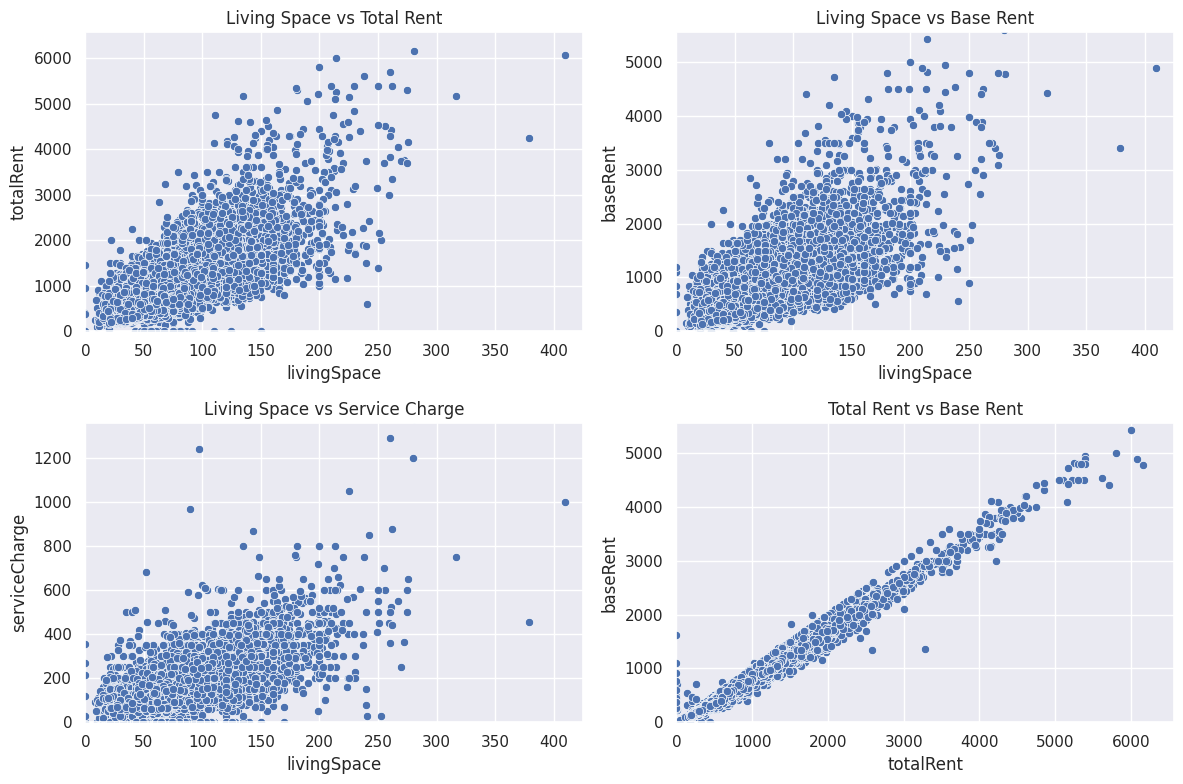

In [121]:
plot_df = apartment_df[['totalRent', 'baseRent','serviceCharge', 'livingSpace']].copy()
plot_df = plot_df[plot_df.notnull().all(1)]
plot_df = plot_df.sample(frac=0.1)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Define a function to create a scatter plot
def scatter_plot(plot_df, x, y, title, ax):
    sns.scatterplot(data=plot_df, x=x, y=y, ax=ax)
    ax.set_title(title)
    ax.set_xlim([0, plot_df[x].quantile(.9999)])
    ax.set_ylim([0, plot_df[y].quantile(.9999)])

# Create the scatter plots
scatter_plot(plot_df, 'livingSpace', 'totalRent', 'Living Space vs Total Rent', axes[0, 0])
scatter_plot(plot_df, 'livingSpace', 'baseRent', 'Living Space vs Base Rent', axes[0, 1])
scatter_plot(plot_df, 'livingSpace', 'serviceCharge', 'Living Space vs Service Charge', axes[1, 0])
scatter_plot(plot_df, 'totalRent', 'baseRent', 'Total Rent vs Base Rent', axes[1, 1])

plt.tight_layout()

* Top left plot shows there are unreasonable values of `livingSpace` and `totalRent`. Plenty of `livingSpace`'s values near zeros or more than 350 $m^2$. Similarly for `totalRent` case, extreme values near zeros and very large values as $11 000$ euros/month.
* Lower left graph show the same problems for `serviceCharge`
* There are strong colinearlity of `totalRent` and `baseRent`, it makes sense since `totalRent` ~ `baseRent` + `serviceCharge`. However, there are some exeptions that needed to be filtered.

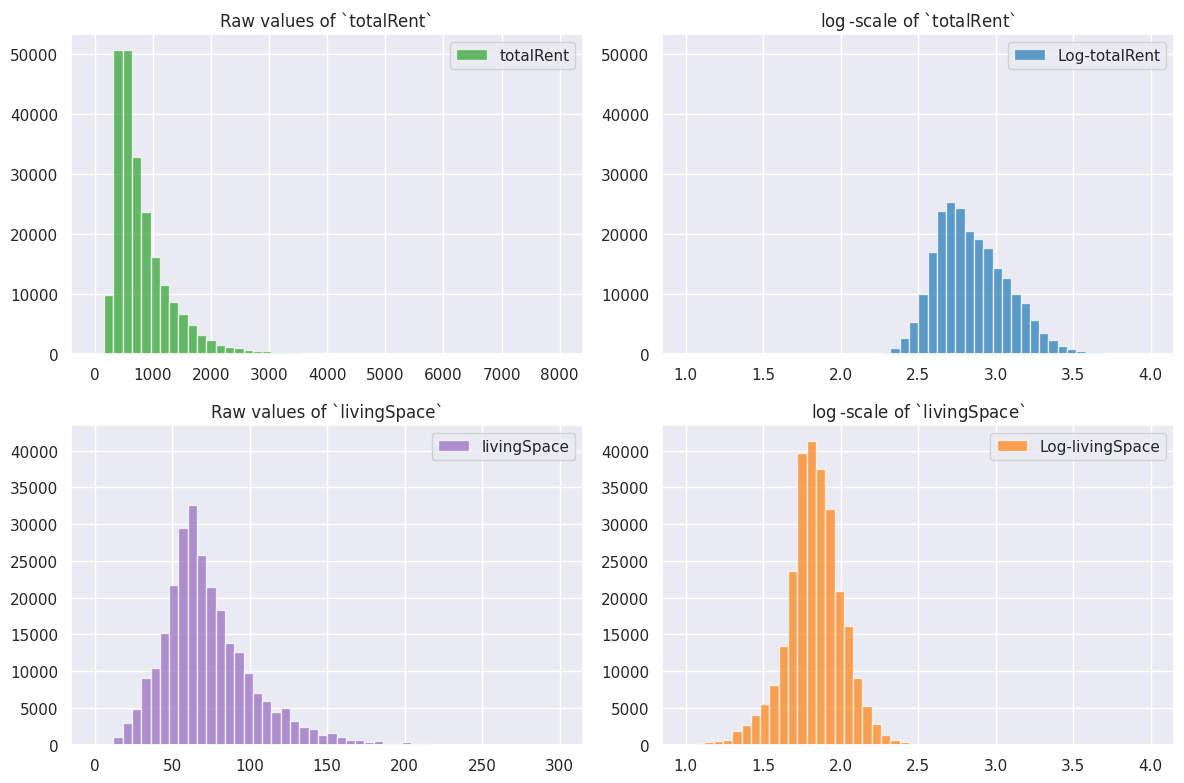

In [122]:

def hist_plot(x, num_bins, x_lim, color, x_label, title, ax):
    ax.hist(x, num_bins, range=x_lim, color=color, label=x_label, alpha=0.7)
    ax.set_title(title)
    ax.legend()

total_rent_log = cp.log10(apartment_df['totalRent']).get()
livespace_log = cp.log10(apartment_df['livingSpace']).get()

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), tight_layout=True)
axes[0, 0].sharey(axes[0, 1])
hist_plot(apartment_df['totalRent'], 50, [0, 8e3], 'tab:green',
           'totalRent', 'Raw values of `totalRent`', axes[0, 0])
hist_plot(total_rent_log, 50, [1, 4], 'tab:blue',
           'Log-totalRent', r'$\log$-scale of `totalRent`', axes[0, 1])

axes[1, 0].sharey(axes[1, 1])
hist_plot(apartment_df['livingSpace'], 50, [0, 300], 'tab:purple',
           'livingSpace', 'Raw values of `livingSpace`', axes[1, 0])
hist_plot(livespace_log, 50, [1, 4], 'tab:orange',
           'Log-livingSpace', r'$\log$-scale of `livingSpace`', axes[1, 1])

The graphs above show the data are skew seriouly. When transforming the data to $\log$-scale, they are closer to the normal distribution. This properties of this dataset in $\log$-space will be employed for the effectiveness of outlier detection and buil machine learning model.

* Show the skewness of data:

|Sknewness| Note|
| ------- | --- |
|[-0.5, 0.5] | fairly symmetrical|
|[-1.0, -0.5]  | moderately right skewed|
|[0.5, 1.0]  | moderately left skewed|
|-1< or > 1 | highly skewed|


## 2.2 Outliers detection process

Since the method (Leys et al. (2023))does not mention about the treatments of catalogue data type, therfore, only numeric data are concerned. Also, for this work, normal distribution type is refered. The outlier cleaning process are as follows:
 1. Numeric columns with `non-NAN` values are cloned for the outliers clean process.
 2. Transform the highly skewed columns into log-space, determine, and store outliers' indices.
 2. Store the idices of ouliers for each numeric column.
 3. Drop all rows containing the outliers of the original dataframe using the stored indices. 

**Remark 1**: Logarithmic transformation push a skewed distribibution closer to the *normal distribution*. When applied to a positively skewed distribution (where the majority of data points are on the left side and the tail extends to the right), the log transformation tends to compress the larger values and spread out the smaller values. This has the effect of making the distribution more symmetric and closer to a normal distribution.

**Remark 2**: Removing outliers makes the statistical properties more representative of the majority of the data, and should be performed before filling missing data. It is beneficial since this work will employ median for imputation.

In [123]:
# Get all numeric columns and assign to temp dataframe
numeric_df = apartment_df.select_dtypes(include=['number']).copy()

In [124]:
# No hypothetical flat are allowed !
numeric_df = numeric_df.drop(numeric_df[numeric_df['yearConstructed'] > 2021].index)

In [125]:
# column `floor` have min. val. < 0, which cannot apply $log$-scale.
# Modify the foolor columns for cleaning
numeric_df['floor'] = numeric_df['floor'] + 1.0

In [126]:
# Skewness of each numeric column before cleaning outliers
numeric_df.skew(axis=0, skipna=True).sort_values(ascending=False)

baseRent           500.195487
totalRent          466.561437
serviceCharge      409.161958
livingSpace        373.834813
noRooms            249.534429
floor              155.438087
picturecount         1.808720
geo_plz              0.430634
pricetrend           0.383596
yearConstructed     -4.565230
dtype: float64

Manually inspection is needed for choosing the threshold factor $k$ of the MAD rejection criteria. By reviewing the results of the bounds combining with domain knowlege is needed to make sure it is appropriate for the dataset. For example:
It is appropriated for the `yearConstructed` contains values lower than the year: 1600s, since there are accient buildings in Germany.
 
All heavily skewed columns should be transformed. 

In [127]:
# Initialize a dictionary to store the bounds and outlier indices
bounds_and_outliers = {}

scale_col = ['baseRent', 'totalRent','serviceCharge','livingSpace', 'noRooms', 'floor', 'yearConstructed']
# Need manual inspection
threshold = [[3,3], [3,3.5], [3, 3.5], [5., 4.], [3., 3.], [4, 4.], [12.,3]]


for col, k in zip(scale_col, threshold):
    # Drop NaN values
    clean_col = numeric_df[col][numeric_df[col].notna()]
    # Check values before applying log-scale transformation
    assert clean_col.min() >= 0
    # Transform to log-scale
    log_col = cp.log1p(clean_col)    

    # Get the boundary of ouliers
    lower_, upper_  = compute_mad_1d(log_col, k)
    upper, lower = cp.expm1(upper_), cp.expm1(lower_)

    print('='*40)
    print(f'Corrected range for {col}:')
    print(f'{lower:2f} < {col} < {upper:2f}')
    print(f'Number of outliers (lower): {clean_col[clean_col < lower].shape[0]}')
    print(f'Number of outliers (upper): {clean_col[clean_col > upper].shape[0]}')
    # Find the outliers
    outliers = numeric_df[(numeric_df[col] < lower) | (numeric_df[col] > upper)]
    numeric_df = numeric_df.drop(outliers.index)
    print("Shape", numeric_df.shape[0])

Corrected range for baseRent:
72.844804 < baseRent < 3263.698197
Number of outliers (lower): 176
Number of outliers (upper): 1133
Shape 267534
Corrected range for totalRent:
127.590080 < totalRent < 4288.975373
Number of outliers (lower): 286
Number of outliers (upper): 16
Shape 267232
Corrected range for serviceCharge:
28.923240 < serviceCharge < 794.531882
Number of outliers (lower): 3872
Number of outliers (upper): 82
Shape 263278
Corrected range for livingSpace:
11.603145 < livingSpace < 264.235472
Number of outliers (lower): 192
Number of outliers (upper): 155
Shape 262931
Corrected range for noRooms:
0.479228 < noRooms < 9.816452
Number of outliers (lower): 0
Number of outliers (upper): 37
Shape 262894
Corrected range for floor:
-0.276524 < floor < 21.115453
Number of outliers (lower): 0
Number of outliers (upper): 53
Shape 262841
Corrected range for yearConstructed:
1589.345985 < yearConstructed < 2081.264775
Number of outliers (lower): 225
Number of outliers (upper): 0
Shape 26

In [128]:
# Verifying skewness of each numeric column ater cleaning outliers
numeric_df.skew(axis=0, skipna=True).sort_values(ascending=False)

floor              1.991502
baseRent           1.977961
totalRent          1.923496
picturecount       1.831201
serviceCharge      1.516230
livingSpace        1.293129
noRooms            0.541794
geo_plz            0.451301
pricetrend         0.394215
yearConstructed   -1.290971
dtype: float64

The skewness is signigicantly improved!

In [129]:
list_outlier_idx = apartment_df.select_dtypes(include=['number']).index.difference(numeric_df.index).tolist()
print(f"Total ouliers dectected: {len(list_outlier_idx)}")
outliers_percent = 100 * (len(list_outlier_idx) / apartment_df.shape[0])
print(f'Percentage of outliers: {outliers_percent:3f} %')

Total ouliers dectected: 6234
Percentage of outliers: 2.318765 %


* Finally, Drop all the outliers using their indices

In [130]:
apartment_clean_df = apartment_df.drop(list_outlier_idx)

## 2.3 Missing value inputation

### 2.3.1 Filling `serviceCharge` values using median service charge of their respective city

Asumme that the service charges such as TV, internet, etc.. are not varying too much in the same city/town.\
Filling missing `serviceCharge` values with the median `serviceCharge` of their respective city (`regio2`). 

In [131]:
service_full = apartment_clean_df[['regio2', 'serviceCharge']].copy()
# Calculate the median service charge for each city
# `median` function automatically ignore NaN values
city_median_service = service_full.groupby('regio2')['serviceCharge'].transform('median')
# Fill missing values
service_full['serviceCharge'].fillna(city_median_service, inplace=True)

# Add to the main df
apartment_clean_df['serviceCharge'] = service_full['serviceCharge']

### 2.3.2 Filling `totalRent` values using data from `baseRent` + `serviceCharge` 

In [132]:
# Current missing value rate
total_rent_df = apartment_clean_df[['totalRent', 'baseRent', 'serviceCharge']].copy()
count_missing_values(total_rent_df)

,Missing count,Percentage
totalRent,39931,15.20509
baseRent,0,0.00000
serviceCharge,0,0.00000


From the data description: Total rent (usually a sum of base rent, service charge and heating cost). So
* The strategy is assume `totalRent` = `baseRent` + `serviceCharge` + **heatingCost**

In [133]:
tol = 5  # make tolerant to 5 euros
totalrent_nan_idx = total_rent_df[total_rent_df['totalRent'].isna()].index

# The residue of total rent - (base rent + service charge)
total_rent_df['residue'] = total_rent_df['totalRent'] \
    - (total_rent_df['baseRent'] + total_rent_df['serviceCharge'])

# Compute the percentage of exact, possitive, negative of residue
poss = total_rent_df['residue'][total_rent_df['residue']
            > tol].count() / total_rent_df['residue'].shape[0]
neg = total_rent_df['residue'][total_rent_df['residue']
           < -tol].count() / total_rent_df['residue'].shape[0]
exact = 1 - poss - neg

print(f'Percentage of zero residue: {100 * exact:.2f} %')
print(f'Percentage of positive residue: {100 * poss:.2f} %')
print(f'Percentage of negative residue: {100 * neg:.2f} %')

Percentage of zero residue: 72.46 %
Percentage of positive residue: 25.59 %
Percentage of negative residue: 1.95 %


- The results show that the reported `totalRent` is acctually a combination of `baseRent` and `serviceCharge` accounted for $72.46 \%$. This indicates the listings posted every charges as a lum sum charge.
- $25.59 \%$ possitive value can be assumed to be the `heatingCosts` (this column is dropped in previous step because its missing percentage upto 70%).
- $1.95 \%$ of the listings have negative values of residue indicating there are probplems.

Note: these results are not taken in account `NaN` rows

Filling `NaN` in total rent column. Also, to keep the statistical properties, $25.59 \%$ of the recently filled values are added with the median of possitive residue

In [134]:
# Sum values of base rent and service charge at such indices
rent_sum_val = total_rent_df.loc[totalrent_nan_idx, 'baseRent'] + total_rent_df.loc[totalrent_nan_idx, 'serviceCharge']

# When dropping the negative residue value the statistic numbers will change
# Recompute the possitive vals rate
poss_new = total_rent_df['residue'][total_rent_df['residue'] > tol].count() / total_rent_df['residue'].shape[0]

# Plus the median of service charge as additional costs for poss_new fraction
poss_fraction = rent_sum_val.sample(frac=poss_new, random_state=2024)
rent_sum_val.loc[poss_fraction.index] += total_rent_df['residue'][total_rent_df['residue'] > tol].median()

# Fill NaN values from the sum to the main dataframe
total_rent_df.loc[totalrent_nan_idx,'totalRent'] = rent_sum_val

Dropping all the rows that have negative value of residue.

In [135]:
# Drop rows with negative residue
neg_index = total_rent_df['residue'][total_rent_df['residue'] < -tol].index
print(f'Number of rows will be dropped: {len(neg_index)}')
apartment_clean_df['totalRent'] = total_rent_df['totalRent']
apartment_clean_df = apartment_clean_df.drop(neg_index)

Number of rows will be dropped: 5115


In [136]:
count_missing_values(apartment_clean_df['totalRent'])

,Missing count,Percentage
totalRent,0,0.0


### 2.3.3 Filling other numeric data

In [137]:
count_missing_values(apartment_clean_df)

,Missing count,Percentage
condition,63308,24.585536
yearConstructed,53525,20.786327
floor,47742,18.540511
heatingType,40535,15.741686
typeOfFlat,33631,13.060532
pricetrend,1775,0.689318
serviceCharge,0,0.000000
newlyConst,0,0.000000
balcony,0,0.000000
picturecount,0,0.000000


In [138]:
# Define the columns to impute
columns_to_impute = ['yearConstructed', 'floor', 'pricetrend']

apartment_clean_df[columns_to_impute] = apartment_clean_df[columns_to_impute].apply(pd.to_numeric, errors='coerce')
apartment_clean_df = apartment_clean_df.fillna()

In [139]:
apartment_clean_df[columns_to_impute] = apartment_clean_df[columns_to_impute].fillna(apartment_clean_df[columns_to_impute].median())

In [140]:
apartment_clean_df[columns_to_impute]


,yearConstructed,floor,pricetrend
0,1965.0,1.0,4.62
1,1871.0,2.0,3.47
2,2019.0,3.0,2.72
3,1964.0,3.0,1.53
4,1950.0,1.0,2.46
...,...,...,...
268845,2016.0,2.0,2.74
268846,1983.0,1.0,6.49
268847,1965.0,1.0,2.90
268848,2019.0,2.0,4.39


### 2.3.4 Filling catalogues data

In [141]:
catalog_df = apartment_clean_df.select_dtypes(include='object').copy().astype('category')
# Define the columns to impute
columns_cat_to_impute = ['condition', 'heatingType', 'typeOfFlat']

In [142]:
# Percentage of each type
cond_percent1 = 100*(catalog_df['condition'].value_counts() / catalog_df.shape[0])
print(cond_percent1)
print(f'Total: {sum(cond_percent1)}')

well_kept                             25.193300
refurbished                           10.249281
fully_renovated                        9.936272
first_time_use                         8.228318
mint_condition                         8.106376
modernized                             6.474538
first_time_use_after_refurbishment     5.866773
negotiable                             0.837278
need_of_renovation                     0.521163
ripe_for_demolition                    0.001165
Name: condition, dtype: float64
Total: 75.41446440984694


In [143]:
catalog_df = categorical_imputation(catalog_df, columns_cat_to_impute)


Iteration: 0
Iteration: 1


In [144]:
# Percentage of each type
cond_percent_forest = 100*(catalog_df['condition'].value_counts() / catalog_df.shape[0])
print(cond_percent_forest)
print(f'Total: {sum(cond_percent1)}')

well_kept                             25.197960
fully_renovated                       14.117615
need_of_renovation                    13.688102
mint_condition                        11.879954
refurbished                           10.403843
modernized                             8.593753
first_time_use                         8.312589
first_time_use_after_refurbishment     6.310267
negotiable                             1.290480
ripe_for_demolition                    0.205436
Name: condition, dtype: float64
Total: 75.41446440984694


In [145]:
# Percentage of each type
cond_percent1 = 100*(catalog_df['typeOfFlat'].value_counts() / catalog_df.shape[0])
print(cond_percent1)
print(f'Total: {sum(cond_percent1)}')

apartment              49.540390
ground_floor           18.182454
roof_storey            13.014707
half_basement           7.312593
other                   3.461346
maisonette              3.454744
raised_ground_floor     2.132419
penthouse               1.281160
terraced_flat           1.261354
loft                    0.358834
Name: typeOfFlat, dtype: float64
Total: 100.00000000000003


In [146]:
count_missing_values(catalog_df)

,Missing count,Percentage
heatingType,0,0.0
condition,0,0.0
typeOfFlat,0,0.0
regio2,0,0.0


In [147]:
apartment_clean_df[columns_cat_to_impute] = catalog_df[columns_cat_to_impute]

In [148]:
count_missing_values(apartment_clean_df)


,Missing count,Percentage
serviceCharge,0,0.0
heatingType,0,0.0
newlyConst,0,0.0
balcony,0,0.0
picturecount,0,0.0
pricetrend,0,0.0
totalRent,0,0.0
yearConstructed,0,0.0
hasKitchen,0,0.0
cellar,0,0.0


# 3. Features engineering

## 3.1 Convert all location data to the distance from them to **Stuttgart** (48.7758° N, 9.1829° E)
The rental price of apartment ... uhm ... uhm, Location, Location, and Location.

The location is important features for predicting rental prices. These features can provide valuable spatial information that may contribute to the model's predictive power. This dataset has 6 columns related to location, which can greatly reduce to one column `distance`.\
The distance to a specific location is measurable, numeric, and distinct, will work nicely for regression model. Stuttgart is chosen for reference point.


The data for coordinates is from: https://gist.github.com/iteufel/af379872bbc3bf5261e2fd09b681ff7e.\
Then, it is converted to csv using function `sql2csv` in `src/data_processing.py`

In [149]:
zip_coordinates = pd.read_csv('../data/zip_coordinates.csv', header=0)

Matching the zipcodes with col. `geo_plz`, then add the corresponding latitude and longitude coordinate.

In [150]:
merged_df = pd.merge_asof(apartment_clean_df.sort_values('geo_plz'),
                               zip_coordinates[['zipcode','lat', 'lon']].sort_values('zipcode'),
                               left_on='geo_plz', right_on='zipcode',
                               direction='nearest')

In [151]:
# Verifying the results
verification_result = merged_df['geo_plz'] == merged_df['zipcode']

# Count the number of discrepancies
num_discrepancies = verification_result.value_counts()
percent = 100 * (num_discrepancies[False] / merged_df.shape[0])
# Display the verification result
print("Verification Result:")
print(f"Matched: {num_discrepancies[True]}")
print(f"Mismatched: {num_discrepancies[False]} ({percent:2f} %)")

Verification Result:
Matched: 256236
Mismatched: 1265 (0.491260 %)


* The mismatched is only about $0.5 \%$, so far so good. Compute the distance from Stuttgart ($48.7758° N, 9.1829° E$) for all the rows.

In [152]:
# Reference coordinates for Stuttgart
ref_lat = 48.7758
ref_lon = 9.1829
# Create a new column 'distance' using the haversine_distance_cudf function
merged_df['distance'] = haversine_distance(merged_df['lat'],
                                           merged_df['lon'],
                                           ref_lat, ref_lon)

In [153]:
merged_df['distance'].describe()

count    257501.000000
mean        335.582935
std         132.203521
min           0.842192
25%         278.961067
50%         342.334535
75%         406.225747
max         716.405714
Name: distance, dtype: float64

The statistics is appropriatley and make sense: $min >0$, $std = 133$

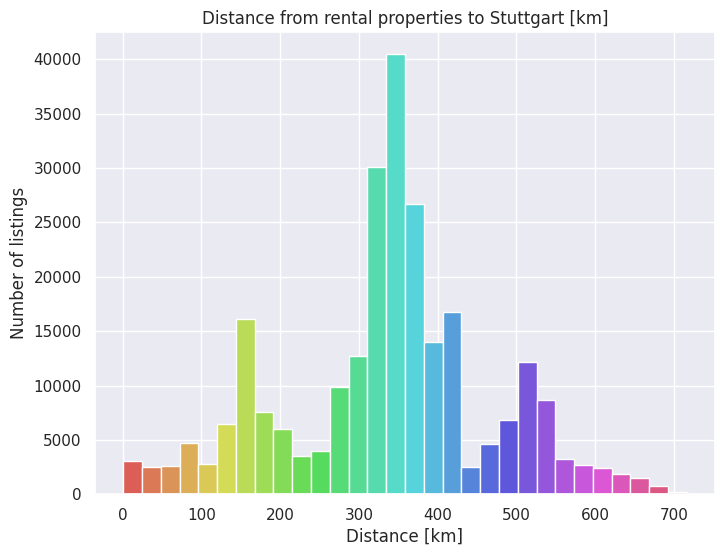

In [154]:
plot_custom_histogram(merged_df, x='distance', xlabel="Distance [km]", ylabel="Number of listings",
                       title="Distance from rental properties to Stuttgart [km]")


Now, distance will present the influence of locations, drop all other location related colmns

In [155]:
merged_df = merged_df.drop(['geo_plz','zipcode', 'lat', 'lon'], axis=1)

In [156]:
merged_df

,serviceCharge,heatingType,newlyConst,balcony,picturecount,pricetrend,totalRent,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,noRooms,floor,garden,regio2,distance
0,158.00,central_heating,False,True,13,2.29,623.0,1985.0,False,True,465.0,78.70,modernized,False,other,3.0,2.0,False,Plauen,413.262119
1,74.00,electric_heating,False,True,6,3.70,272.0,1985.0,False,True,198.0,45.00,mint_condition,False,other,2.0,2.0,False,Plauen,413.262119
2,225.00,electric_heating,False,True,15,2.29,978.0,1985.0,True,True,753.0,112.31,first_time_use_after_refurbishment,False,maisonette,4.0,3.0,False,Plauen,413.262119
3,130.00,central_heating,False,False,6,1.92,520.0,1900.0,False,True,390.0,49.15,refurbished,False,roof_storey,2.0,3.0,False,Dresden,413.262119
4,130.00,central_heating,False,False,6,2.19,520.0,1900.0,False,True,390.0,49.15,refurbished,False,roof_storey,2.0,3.0,False,Dresden,413.262119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257496,80.00,gas_heating,True,True,40,1.84,480.0,2019.0,False,True,320.0,72.00,fully_renovated,False,apartment,3.0,0.0,True,Unstrut_Hainich_Kreis,294.172476
257497,80.00,gas_heating,True,True,40,1.84,480.0,2019.0,False,True,320.0,72.00,fully_renovated,False,apartment,4.0,0.0,True,Unstrut_Hainich_Kreis,294.172476
257498,58.25,combined_heat_and_power_plant,False,True,4,1.99,479.0,1997.0,False,False,363.0,58.25,mint_condition,False,ground_floor,2.0,2.0,False,Unstrut_Hainich_Kreis,294.172476
257499,100.00,combined_heat_and_power_plant,False,False,8,1.75,500.0,1985.0,False,False,400.0,120.00,mint_condition,False,ground_floor,4.0,2.0,False,Unstrut_Hainich_Kreis,290.913886
